#Peer-graded Assignment: Week 3: Histopathologic  Cancer Detection Kaggle Mini-Project

This Kaggle competition (https://www.kaggle.com/competitions/histopathologic-cancer-detection) is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans.

The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others' submissions. Note: to receive total points for this section, the learner doesn't need to have a top-performing score on the challenge. As a mini-project to complete as a weekly assignment, we don't expect you to iterate over your project until you have a model capable of winning the challenge. The iterative process takes time, so please start early to get better-quality results and reports. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project. The grades are more based on the quality and depth of the analysis, not just on a better Kaggle score.

# Brief description of the problem and data (5 pts)  

The central problem of this project is to use Deep Learning to develop a high-accuracy algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

The Kaggle website provides a library of 96x96px pathology images in .tif format. From the Kaggle description a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

As with all machine learning/data mining projects, the starting point is always to perform an EDA. We are looking for imbalances in feature and class values, outliers, missing values, or any other aspects of the data that might look a little out of the ordinary.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data import

In [4]:
os.chdir("drive/My Drive/Week3Project")
!ls

 train	'Week 3 Project.ipynb'


In [5]:
train = pd.read_csv('train/train_labels.csv')
train

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]

The training data has 220025 images, which are labelled as 0 (non-cancerous) or 1 (cancerous).  
From the chart below, there is a good even balance of both classes in the training data.

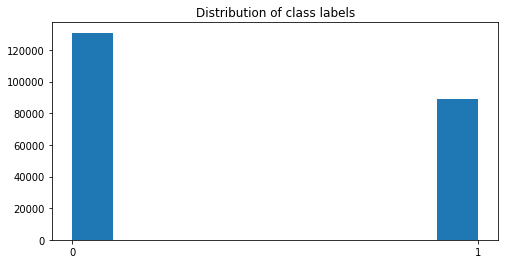

In [8]:
plt.rcParams["figure.figsize"] = (8,4)
plt.hist(train["label"])
plt.title("Distribution of class labels")
plt.xticks([0,1])
plt.show();

The id field references the actual image filename which is stored in a sub-folder /train.  
Lets inspect a random sampling of the images:


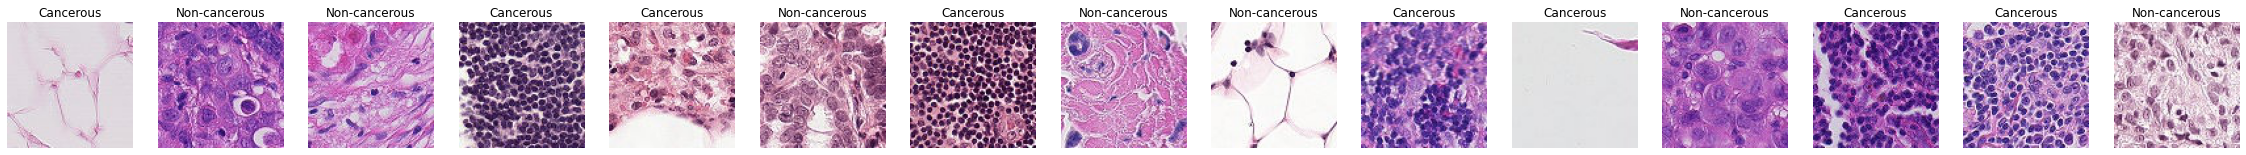

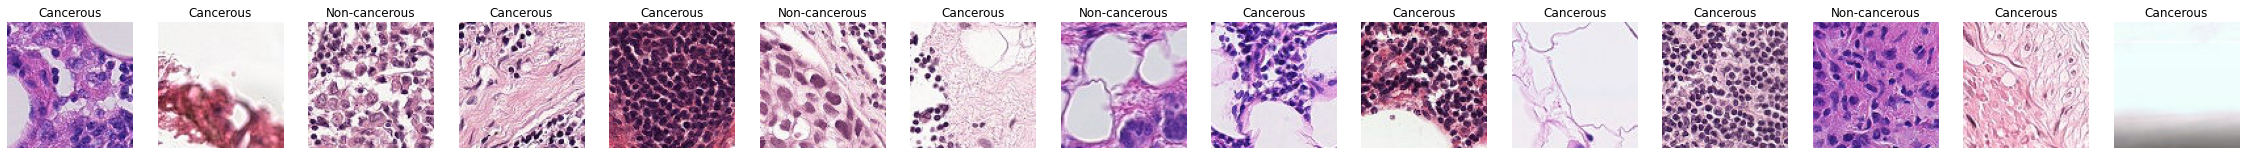

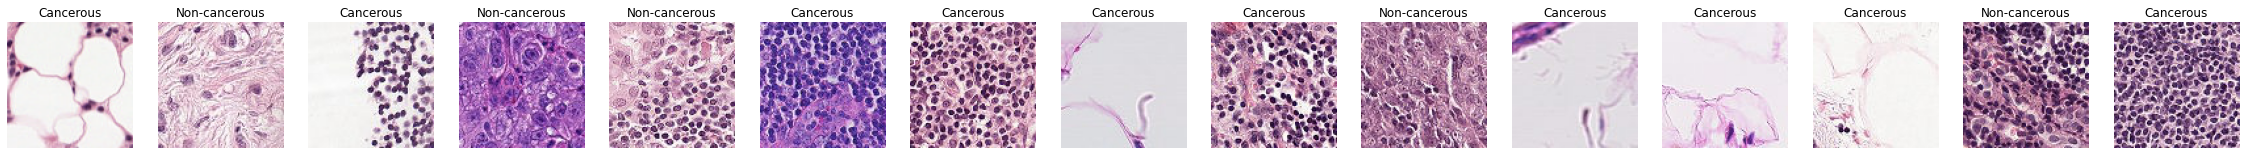

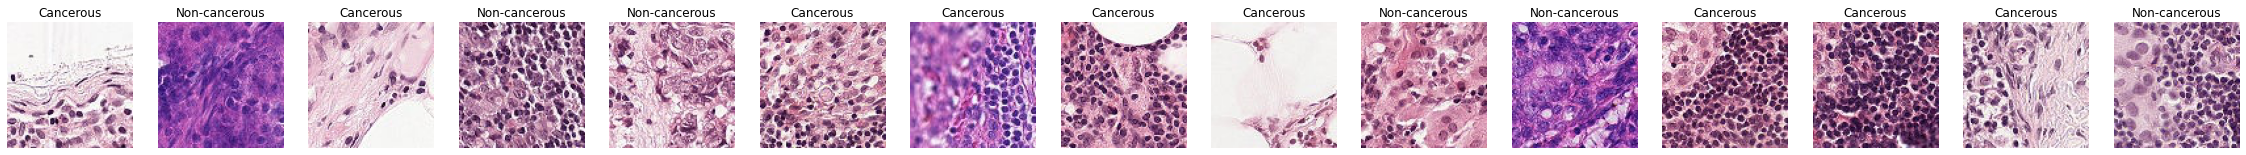

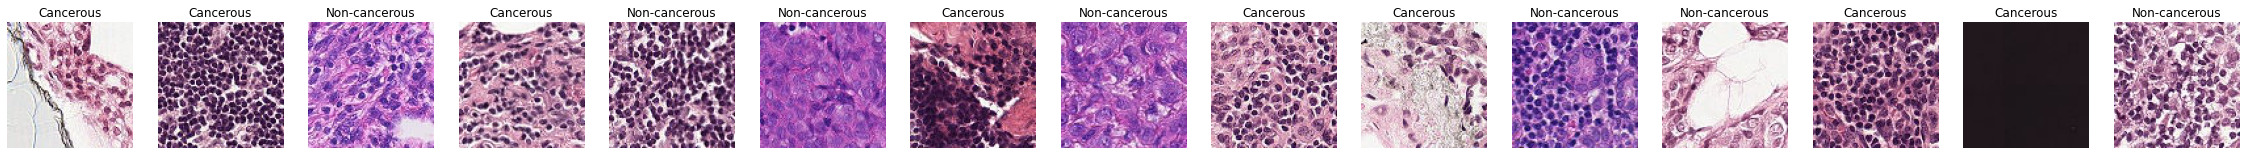

In [ ]:
train_path='train'

plt.rcParams["figure.figsize"] = (40,10)
rowcounter=0
colcounter=0
for root, dirs, files in os.walk(train_path):
  for filename in files:
    if filename.endswith(('tif')):
      colcounter+=1
      image = plt.imread(train_path+"/"+filename)
      plt.subplot(1,15,colcounter)
      plt.imshow(image)
      plt.axis('off')
      title= "Cancerous" if (train.loc[train["id"]==filename[0:-4]]["label"]==0).tolist()[0] else "Non-cancerous"
      plt.title(title)
      if colcounter>14:
        rowcounter+=1
        colcounter=0
        plt.show();
        if rowcounter>4: break

I have no idea what cancerous tissue may or may not look like, but these images certainly seem reasonable.  
We had some friends over for dinner - a retired doctor - and I showed him the above images, which he studied with great interest. The reason they appear purple is because of a dye added to the tissue which causes certain tissue features to appear darker and easier to see. In general, the smaller darker and denser "dots" are more likely to be the cancerous cells. He also remarked that trainee doctors are sometimes surprised when they observe a real surgery to discover that the tissue is not purple as in the books, but red :-)

# Data cleansing
From the above images, it can be seen that one is completely black, and others are almost completely white.  
It is better to remove these from the dataset before model training.  
I messed around with this waaaaay longer than I should have, but after lots of trial and error found the following idea worked quite well:  
Remove any image where 75% or more of the pixels are either all white (>250) or all black (<30)

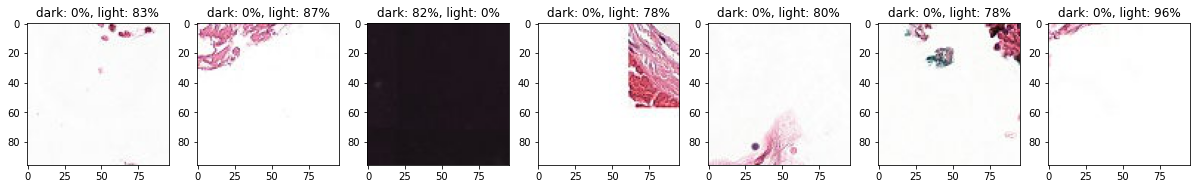

In [ ]:
colcounter=1
plt.rcParams["figure.figsize"] = (30,5)
for root, dirs, files in os.walk(train_path):
  for filename in files:
    if filename.endswith(('tif')):
       image = plt.imread(train_path+"/"+filename)
       image_np=np.array(image).reshape(-1,1)
       pc_image_np_dark=int((image_np<30).sum()/27648*100)
       pc_image_np_light=int((image_np>250).sum()/27648*100)

       if pc_image_np_dark>75 or pc_image_np_light>75:
         plt.subplot(1,10,colcounter)
         plt.title("dark: " + str(pc_image_np_dark) + "%, light: " + str(pc_image_np_light) + "%")
         plt.imshow(image)       
         colcounter+=1
         if colcounter>=15: 
            colcounter=1
            plt.show();
            train = train[train.id == filename[0:-4]] # remove from training dataset

# Model Architecture (25 pts)

Unlike most other machine learning algorithms (SVM, Decision Tree, Naive Bayes, etc), the Neural Network presents an lmost infinite number of topologies and cofigurations! How many layers? How many neurons per layers? Whch activation functions?  
The only way to reasonably approach the architecture design process is to simply copy what others have done.  
For the case of image classification it has been shown by many others that the best approach is to have several Convolution layers, each with the Relu activation function, then a few MLP layers, leading to a final MLP output layer.  
The reason the convolutional layers make so much sense for images, is because (unlike MLP which simply converts the image to a large one dimensional array) the visual features of the images (edges, corners, circles, blotches, etc) are captured during the filter convolution process.
For the implementation, the python keras package will now do virtually all of the heavy lifting for us. In particular, the ImageDataGenerator can directly read a pandas dataframe and generate the training, validation and test datasets!   
The keras library is a very popilar easier-to-use wrapper that sits on top of Tensorflow (which is more technical and has a steeper learning curve).


In [ ]:
#Before running, there are a few housekeeping jobs to keep datagen.flow_from_dataframe happy.
# convert label to string
train["label"]=train["label"].astype(str)
# append .tif file extension
train['id'] = train['id'] + '.tif'

In [ ]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
  dataframe=train,
  directory="train",
  x_col='id',
  y_col='label',
  subset='training',
  class_mode='binary',
  target_size=(96,96))

valid_generator = datagen.flow_from_dataframe(
  dataframe=train,
  directory="train",
  x_col='id',
  y_col='label',
  subset='validation',
  class_mode='binary',
  target_size=(96,96))

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 206663 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 10690 validated image filenames belonging to 2 classes.
Found 2672 validated image filenames belonging to 2 classes.


Now we can experiment with different CNN model configurations!  
There are a huge variety of options for neural network configurations. For this assignment, I will limit to the basic CNN architecture of a few convolutional layers, followed by a few multi-layer perceptron layers, ending in one binary classifier output.

In [11]:
EPOCHS=10  # total number of epochs in each model
model={}   # dictionary to store each model
history={'history':{}} # dictionary to store each model history

In [77]:
# Helper function to plot graph
def plot_model(model_idx, history):
  #plot model accuracy
  plt.rcParams["figure.figsize"] = (15,8)
  plt.plot(history[model_idx]["history"]['accuracy'], label='training accuracy')
  plt.plot(history[model_idx]["history"]['val_accuracy'], label = 'validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()
  plt.xticks(np.arange(0, 10, 1))
  plt.title("Model " + str(model_idx+1) + ": Accuracy vs Training Epoch");

## Model 1



Firstly, I'm curious to run a very simple CNN with only 1 convolutional layer with just 5 filters, just to see how well (or not) it performs.  


In [12]:
optimiser = keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)

model[0] = Sequential()
model[0].add(layers.Conv2D(filters=5, kernel_size=5, strides=3, input_shape=(96, 96, 3), activation='relu', padding = 'same'))
model[0].add(layers.MaxPooling2D(pool_size=(2, 2)))

model[0].add(layers.Flatten())
model[0].add(layers.Dense(100, activation="relu"))
model[0].add(layers.Dense(1, activation='sigmoid'))

model[0].compile(loss='binary_crossentropy', optimizer=optimiser,  metrics=['accuracy'])

In [ ]:
model[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 5)         380       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 5)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 128,581
Trainable params: 128,581
Non-trainable params: 0
__________________________________________________

In [ ]:
history[0] = model[0].fit(train_generator,validation_data=valid_generator,epochs=EPOCHS,batch_size=256, verbose=2)
# Save results to disk
file = open('history0.dat','wb')
pickle.dump(history[0], file)
file.close()

Epoch 1/10
286/335 [========================>.....] - ETA: 20:25 - loss: 0.6383 - accuracy: 0.6254

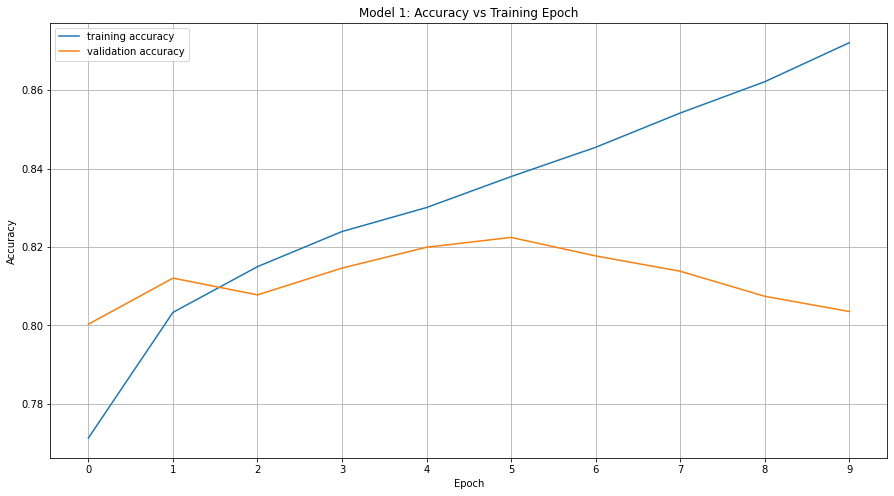

In [78]:
plot_model(0, history)

## Model 2

Lets increase the number of filters in the first convolutional layer from 5 to 100

In [14]:
optimiser = keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)

model[1] = Sequential()
model[1].add(layers.Conv2D(filters=100, kernel_size=5, strides=3, input_shape=(96, 96, 3), activation='relu', padding = 'same'))
model[1].add(layers.MaxPooling2D(pool_size=(2, 2)))

model[1].add(layers.Flatten())
model[1].add(layers.Dense(100, activation="relu"))
model[1].add(layers.Dense(1, activation='sigmoid'))

model[1].compile(loss='binary_crossentropy', optimizer=optimiser,  metrics=['accuracy'])

In [15]:
model[1].summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 100)       7600      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 100)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               2560100   
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,567,801
Trainable params: 2,567,801
Non-trainable params: 0
____________________________________________

In [ ]:
history[1] = model[1].fit(train_generator,validation_data=valid_generator,epochs=EPOCHS,batch_size=256, verbose=2)
# Save results to disk
file = open('history1.dat','wb')
pickle.dump(history[1], file)
file.close()

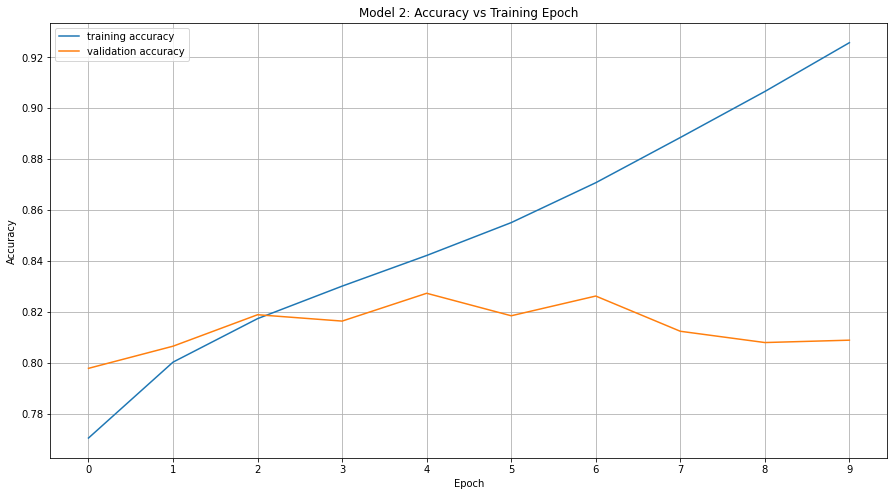

In [81]:
plot_model(1, history)

## Model 3
Now lets add a second convolutional layer, with 50 filters

In [17]:
optimiser = keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)

model[2] = Sequential()
model[2].add(layers.Conv2D(filters=100, kernel_size=5, strides=3, input_shape=(96, 96, 3), activation='relu', padding = 'same'))
model[2].add(layers.MaxPooling2D(pool_size=(2, 2)))

model[2].add(layers.Conv2D(filters=50, kernel_size=5, strides=3, input_shape=(96, 96, 3), activation='relu', padding = 'same'))
model[2].add(layers.MaxPooling2D(pool_size=(2, 2)))

model[2].add(layers.Flatten())
model[2].add(layers.Dense(100, activation="relu"))
model[2].add(layers.Dense(1, activation='sigmoid'))

model[2].compile(loss='binary_crossentropy', optimizer=optimiser,  metrics=['accuracy'])

In [18]:
model[2].summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 100)       7600      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 100)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 50)          125050    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 50)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 450)               0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [ ]:
history[2] = model[2].fit(train_generator,validation_data=valid_generator,epochs=EPOCHS,batch_size=256, verbose=2)
# Save results to disk
file = open('history2.dat','wb')
pickle.dump(history[2], file)
file.close()

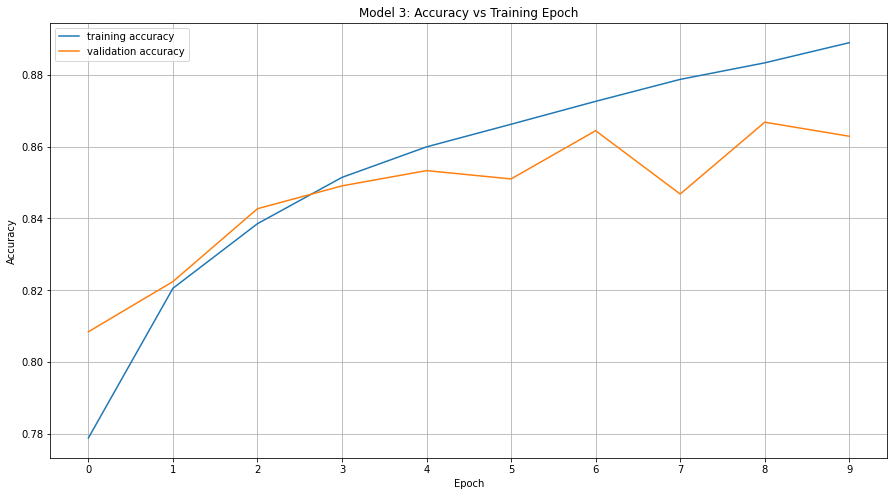

In [83]:
plot_model(2, history)

## Model 4
Now lets add a third convolutional layer, with 25 filters. Any more than this ad the calculation time on this free Google colab account will time out.

In [19]:
optimiser = keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)

model[3] = Sequential()
model[3].add(layers.Conv2D(filters=100, kernel_size=5, strides=3, input_shape=(96, 96, 3), activation='relu', padding = 'same'))
model[3].add(layers.MaxPooling2D(pool_size=(2, 2)))

model[3].add(layers.Conv2D(filters=50, kernel_size=5, strides=3, input_shape=(96, 96, 3), activation='relu', padding = 'same'))
model[3].add(layers.MaxPooling2D(pool_size=(2, 2)))

model[3].add(layers.Conv2D(filters=50, kernel_size=5, strides=3, input_shape=(96, 96, 3), activation='relu', padding = 'same'))

model[3].add(layers.Flatten())
model[3].add(layers.Dense(100, activation="relu"))
model[3].add(layers.Dense(1, activation='sigmoid'))

model[3].compile(loss='binary_crossentropy', optimizer=optimiser,  metrics=['accuracy'])

In [20]:
model[3].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 100)       7600      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 100)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 50)          125050    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 50)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 50)          62550     
                                                                 
 flatten_3 (Flatten)         (None, 50)               

In [ ]:
history[3] = model[3].fit(train_generator,validation_data=valid_generator,epochs=EPOCHS,batch_size=256, verbose=2)
# Save results to disk
file = open('history3.dat','wb')
pickle.dump(history[3], file)
file.close()

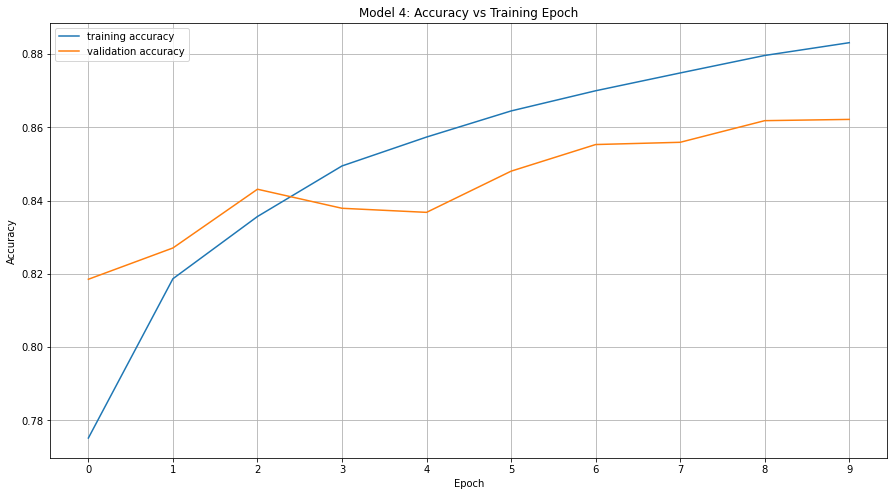

In [86]:
plot_model(3, history)

# Results and Analysis (35 pts) 

During the model archirecture phase, 4 different models were trialled.

The training/validation results are summarised below:



In [ ]:
# Read the results from the previous models back into memory from disk
MODEL_COUNT=4
history={}
for model_idx in range(MODEL_COUNT):
  filename="history" + str(model_idx) + ".dat"
  print(filename)
  file = open(filename, "rb")
  history[model_idx] = pickle.load(file)
  file.close()

In [96]:
#@title
# During development the Google colab kept timing out and disabling the GPU option, so I ran the above code on my laptop and saved the data via pickle.
# For some reason, even though the pickle versions were the same (4.0), the fiels would not open in Google colab.
# To get around this, I copy/pasted the values into this cell!! 
history[0]={}
history[0]['history']={}
history[0]["history"]['accuracy']=[0.7712475657463074, 0.8033007383346558, 0.8149698972702026, 0.8239290714263916, 0.8300533890724182, 0.837955892086029, 0.8454209566116333, 0.8541643023490906, 0.8621520400047302, 0.8721111416816711]
history[0]["history"]['val_accuracy']=[0.8002954125404358, 0.812044084072113, 0.8077718615531921, 0.8146119713783264, 0.8199295401573181, 0.8224292397499084, 0.8177025318145752, 0.8137938976287842, 0.8074082732200623, 0.8035223484039307]
history[1]={}
history[1]['history']={}
history[1]["history"]['accuracy']=[0.7703897356987, 0.8002158999443054, 0.8173048496246338, 0.8300760984420776, 0.8421202301979065, 0.8550335168838501, 0.8707078695297241, 0.8884729146957397, 0.9065560698509216, 0.9257300496101379]
history[1]["history"]['val_accuracy']=[0.797773003578186, 0.8064765334129333, 0.8188387751579285, 0.8163390755653381, 0.8272696137428284, 0.818429708480835, 0.8261788487434387, 0.8123394846916199, 0.8079081773757935, 0.8088399171829224]
history[2]={}
history[2]['history']={}
history[2]["history"]['accuracy']=[0.7788432836532593, 0.8205374479293823, 0.8385297060012817, 0.8514259457588196, 0.8599250316619873, 0.8662197589874268, 0.872599720954895, 0.8787126541137695, 0.8833200931549072, 0.8889330625534058]
history[2]["history"]['val_accuracy']=[0.8084308505058289, 0.822406530380249, 0.8426997065544128, 0.8490626215934753, 0.8533121347427368, 0.8509942293167114, 0.8644245266914368, 0.8467901349067688, 0.866787850856781, 0.86287921667099]
history[3]={}
history[3]['history']={}
history[3]["history"]['accuracy']=[0.7751619219779968, 0.8186626434326172, 0.8356550335884094, 0.8494659662246704, 0.8573571443557739, 0.8644869923591614, 0.8699977397918701, 0.8748608231544495, 0.879638671875, 0.8831269145011902]
history[3]["history"]['val_accuracy']=[0.8185206055641174, 0.827065110206604, 0.8431087136268616, 0.8379048109054565, 0.8367912769317627, 0.848039984703064, 0.8553118705749512, 0.855925440788269, 0.8618338704109192, 0.8621747493743896]


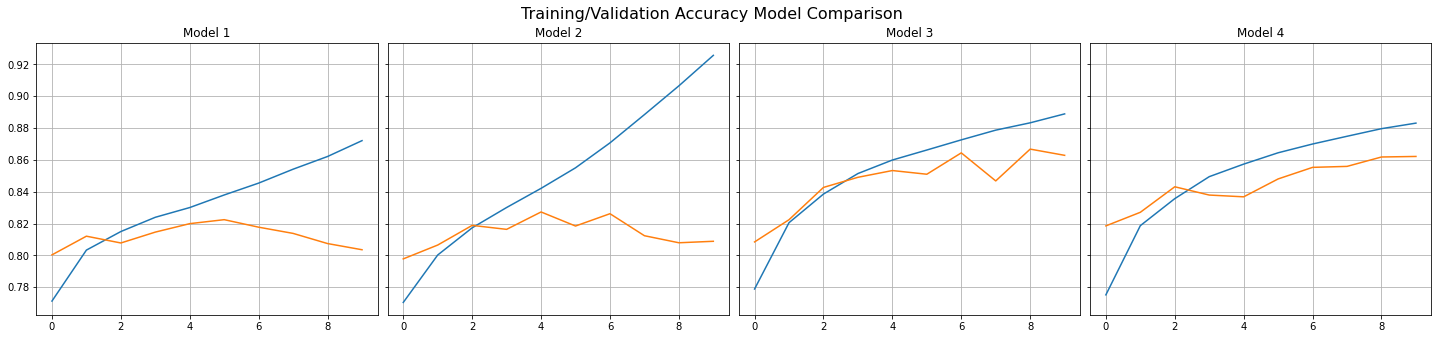

In [123]:
plt.rcParams["figure.figsize"] = (25,5)

fig, ax = plt.subplots(1,4,sharey=True)
fig.subplots_adjust(wspace=0.03)
fig.suptitle('Training/Validation Accuracy Model Comparison', fontsize=16)

for model_idx in range(4):
  ax[model_idx].plot(history[model_idx]["history"]['accuracy'], label='training accuracy')
  ax[model_idx].plot(history[model_idx]["history"]['val_accuracy'], label = 'validation accuracy')
  ax[model_idx].grid()
  ax[model_idx].set_title("Model " + str(model_idx+1))

plt.show();

The four graphs above are very revealing. If only accuracy had been plotted for each of the models, we would have easily come to the wrong conclusion that Model 2 is far better than the other 3, as the accuracy is above 90% after 10 epochs. Howver this conclusion is very wrong, as the model 2 validation accuracy is much lower at around 80%. This tells us that model 2 is seriously overfitting.
Form the 4 plots above, the best overall result is seen with Model 3 after 8 epochs, where there is a shared maximima of training and validation accuracy.

The plot below shows the number of trainable parameters for each of the 4 models:

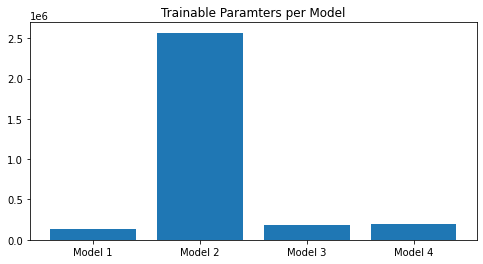

In [24]:
Trainable_Parameters = [128581,2567801,177851,200401]
plt.bar(['Model 1','Model 2','Model 3','Model 4'],Trainable_Parameters)
plt.title("Trainable Parameters per Model");

This plot very clearly shows that "more is not better" when it comes CNN model complexity. In fact, all an overly complex model achieves is to overfit the training data!

# Conclusion (15 pts)

My conclusion from this assignment is that first and foremost you need to be ready to wait an awful long time for these models to train. There seems to be no hard and fast rules around how to set up CNN's (number of layers, number of neurons, type of activation function) so these long wait times are unfortunate as they discourage experimentation with different configurations.  
Therefore I do not doubt that there exists a great many CNN configurations that would perform much better than my 88% acuracy results here, but it is very unclear to me how to go about finding them other than a long process of trial and error.  
That all said, the CNN is an amazing technology!